In [ ]:
#import kaggle dataset
import os
os.environ['KAGGLE_USERNAME'] = "sayanroy728" # username from the json file
os.environ['KAGGLE_KEY'] = "bdc57011dd0a63979dc7191b3a613d73" # key from the json file
!kaggle datasets download -d moltean/fruits # api copied from kaggle

"""from google.colab import drive
drive.mount('/content/gdrive')"""

 97% 716M/734M [00:16<00:00, 29.6MB/s]
100% 734M/734M [00:16<00:00, 46.6MB/s]


"from google.colab import drive\ndrive.mount('/content/gdrive')"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls /content/gdrive/My Drive

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive': No such file or directory


In [ ]:
!unzip -q "/content/fruits.zip"

In [ ]:
import math, random
from pprint import pprint
from datetime import datetime as dt
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
#import keras as k
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import img_to_array

categories = ["Apple Braeburn", "Apricot", "Avocado", "Banana", "Clementine", "Cocos", "Mandarin", "Orange", "Lemon", "Limes", "Peach", "Pineapple", "Plum", "Pomegranate", "Raspberry", "Strawberry"]
n = len(categories)
im_size = 35
target_size = (im_size, im_size)
channels = 1
train_path = "/content/fruits-360_dataset/fruits-360/Training"
validate_path = "/content/fruits-360_dataset/fruits-360/Test"
prediction_path = "/content/predictions"


Using TensorFlow backend.


In [ ]:
#alt train_data_gen = k.preprocessing.keras_preprocessing.image.ImageDataGenerator
train_data_gen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5],
    channel_shift_range=0.05,
    rescale=1./255
)
test_data_gen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
train_generator = train_data_gen.flow_from_directory(train_path, target_size=target_size, color_mode='grayscale', class_mode='categorical', classes=categories, seed=42)
test_generator = test_data_gen.flow_from_directory(validate_path, target_size=target_size, color_mode='grayscale', class_mode='categorical', classes=categories, seed=42)


Found 7245 images belonging to 16 classes.
Found 2434 images belonging to 16 classes.


Continued..

In [ ]:
def get_subplot_grid(mylist, columns, figwidth, figheight):
  plot_rows = math.ceil(len(mylist)/2.)
  fig, ax = plt.subplots(plot_rows, 2, sharex=False, sharey=True)
  fig.set_figwidth(figwidth)
  fig.set_figheight(figheight)
  fig.subplots_adjust(hspace=0.4)
  axflat=ax.flat
  for ax in axflat[ax.size - 1: len(mylist) - 1: -1]:
    ax.set_visible(False)
  return fig, axflat

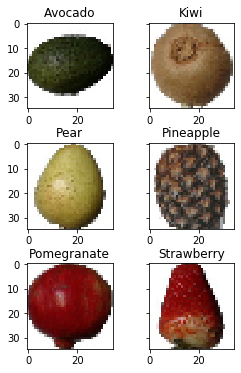

<Figure size 432x288 with 0 Axes>

In [ ]:
from keras_preprocessing.image import img_to_array, load_img
test_images_classes = ["Avocado","Kiwi","Pear","Pineapple","Pomegranate","Strawberry"]
test_images = []

fig, axflat = get_subplot_grid(mylist=test_images_classes, columns=2, figwidth=4, figheight=6)
for idx, label in enumerate(test_images_classes):
    image_folder = os.path.join(train_path, label)
    image_file = os.path.join(image_folder, random.choice(os.listdir(image_folder)) )
    loaded_image =load_img(path=image_file,target_size=(im_size, im_size ,1))
    #convert to array and resample dividing by 255
    img_array = img_to_array(loaded_image) / 255.
    test_images.append({"idx":idx, "image":img_array, "label": label})
    
    axflat[idx].set_title(label, size=12)
    axflat[idx].imshow(img_array)
plt.show()
plt.gcf().clear()

In [ ]:
trained_classes_labels = list(train_generator.class_indices.keys())
pprint(train_generator.class_indices)

{'Apple Braeburn': 0,
 'Apricot': 1,
 'Avocado': 2,
 'Banana': 3,
 'Clementine': 4,
 'Cocos': 5,
 'Lemon': 8,
 'Limes': 9,
 'Mandarin': 6,
 'Orange': 7,
 'Peach': 10,
 'Pineapple': 11,
 'Plum': 12,
 'Pomegranate': 13,
 'Raspberry': 14,
 'Strawberry': 15}


In [ ]:
unique, counts = np.unique(train_generator.classes, return_counts=True)
print("Number of samples per class: ")
pprint(dict(zip(train_generator.class_indices, counts)))

Number of samples per class: 
{'Apple Braeburn': 492,
 'Apricot': 492,
 'Avocado': 427,
 'Banana': 490,
 'Clementine': 490,
 'Cocos': 490,
 'Lemon': 490,
 'Limes': 492,
 'Mandarin': 479,
 'Orange': 492,
 'Peach': 490,
 'Pineapple': 447,
 'Plum': 492,
 'Pomegranate': 490,
 'Raspberry': 492}


Building The Model

In [ ]:
from keras.layers import BatchNormalization, Activation, SpatialDropout2D, LeakyReLU, Dropout
def create_model():
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding = 'same', strides=(1, 1),
                                    input_shape = (im_size, im_size, channels),
                                    #kernel_regularizer=k.regularizers.l2(0.0005),
                                    name='conv2d_1'))
  model.add(BatchNormalization())
  model.add(Activation('relu', name='activation_conv2d_1'))

  model.add(SpatialDropout2D(0.2))
  model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', name='conv2d_2'))
    #normalize the output of different activations
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.5, name='activation_conv2d_2'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Flatten())
    
    # output features onto a dense layer
    #model.add(k.layers.Dense(units = len(trained_classes_labels) * 20, name='dense_1' ) )
  model.add(Dense(units = 250, name='dense_1' ) )
  model.add(Activation('relu', name='activation_dense_1'))

    # randomly switch off 50% of the nodes per epoch step to avoid overfitting
  #model.add(Dropout(0.5))

    # output layer with the number of units equal to the number of categories
  model.add(Dense(units = len(trained_classes_labels), name='dense_2'))
  model.add(Activation('softmax', name='activation_final'))

  return model


my_model = create_model()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [ ]:
from keras.optimizers import RMSprop
my_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr=1e-4))# ,decay=1e-6))

Train The Model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
start=dt.now()
history = my_model.fit_generator(
    train_generator,
    #epochs
    steps_per_epoch = train_generator.n// 32,
    epochs = 20,

    validation_data = test_generator,
    validation_steps = test_generator.n // 32, #Batch size = 32

    #Printing progress
    verbose = 1,
    callbacks = [
                 EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint("fruits_checkpoints.h5", monitor='val_loss', save_best_only=True),
                 TensorBoard(log_dir="logs/{:%d_%b_%Y_%H:%M:%S}".format(dt.now()))

    ]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/20
226/226 [==============================] - 175s 777ms/step - loss: 1.4746 - acc: 0.5477 - val_loss: 0.8612 - val_acc: 0.7336

Epoch 2/20
226/226 [==============================] - 174s 770ms/step - loss: 0.6499 - acc: 0.7772 - val_loss: 0.6253 - val_acc: 0.7756
Epoch 3/20
226/226 [==============================] - 174s 769ms/step - loss: 0.4148 - acc: 0.8581 - val_loss: 0.5891 - val_acc: 0.8118
Epoch 4/20
222/226 [============================>.] - ETA: 2s - loss: 0.3182 - acc: 0.8896

Plot the data

In [ ]:
model.save('')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch

model_save_name = 'classifier_withoutdropout.pt'
path = F"/content/drive/My Drive/iiti intern/{model_save_name}"
torch.save(my_model, path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


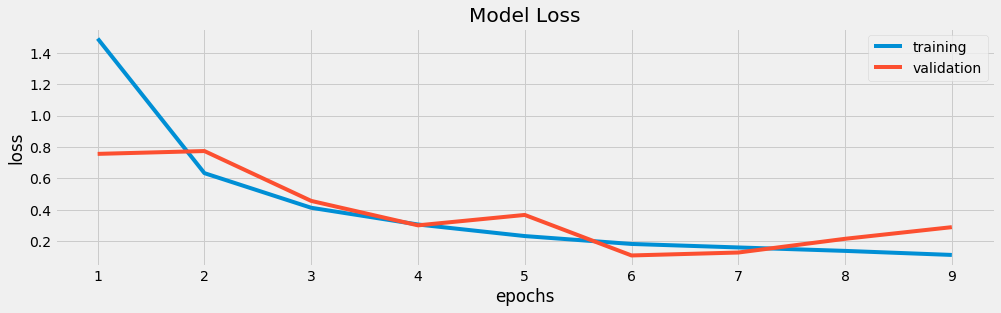

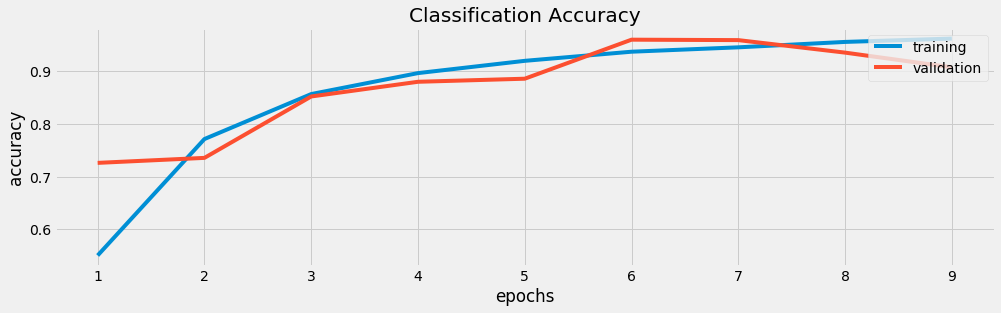

In [ ]:
print(history.history.keys())
plt.style.use('fivethirtyeight')

#loss
xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(15,9))
plt.subplot(2,1,1)
plt.title('Model Loss')
plt.plot(xepochs, history.history['loss'])
plt.plot(xepochs, history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#Accuracy
xepochs = [i+1 for i in range(0, len(history.history['loss']))]
plt.figure(figsize=(15,9))
plt.subplot(2,1,1)
plt.title('Classification Accuracy')
plt.plot(xepochs, history.history['acc'])
plt.plot(xepochs, history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
df_out= {'val_loss: ': history.history['val_loss'][0], 'val_acc': history.history['val_acc'][0]*100, 'elapsed time:': (dt.now() - start).seconds}
print(df_out)

{'val_loss: ': 1.000393860434231, 'val_acc': 62.25328947368421, 'elapsed time:': 1148}


In [ ]:
my_model = create_model()
my_model.load_weights("fruits_checkpoints.h5")
my_model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=RMSprop(lr=1e-4)
)
print("Model created, weights from file loaded.")

Model created, weights from file loaded.


In [ ]:
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 35, 35, 64)        640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 35, 35, 64)        256       
_________________________________________________________________
activation_conv2d_1 (Activat (None, 35, 35, 64)        0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 128)       73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 35, 35, 128)       512       
_________________________________________________________________
activation_conv2d_2 (LeakyRe (None, 35, 35, 128)      

# Prediction 

In [ ]:
!unzip -q "/content/predictions.zip"

replace predictions/avocado-violence-ziracuaretiro-mexico-shutterstock-editorial-10453468c.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


{'Apple Braeburn': '0.00%',
 'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '84.31%',
 'Clementine': '0.00%',
 'Cocos': '0.00%',
 'Lemon': '0.00%',
 'Limes': '0.01%',
 'Mandarin': '0.00%',
 'Orange': '0.00%',
 'Peach': '0.00%',
 'Pineapple': '0.00%',
 'Plum': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '15.68%',
 'Strawberry': '0.00%'}
Prediction: Banana (class 3) 84.31%


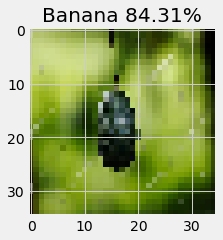

{'Apple Braeburn': '0.43%',
 'Apricot': '0.00%',
 'Avocado': '27.41%',
 'Banana': '0.01%',
 'Clementine': '0.00%',
 'Cocos': '16.22%',
 'Lemon': '0.00%',
 'Limes': '0.00%',
 'Mandarin': '0.00%',
 'Orange': '0.00%',
 'Peach': '0.00%',
 'Pineapple': '1.07%',
 'Plum': '0.44%',
 'Pomegranate': '0.18%',
 'Raspberry': '0.01%',
 'Strawberry': '54.23%'}
Prediction: Strawberry (class 15) 54.23%


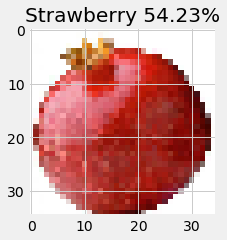

{'Apple Braeburn': '0.00%',
 'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Cocos': '0.00%',
 'Lemon': '0.00%',
 'Limes': '0.00%',
 'Mandarin': '0.00%',
 'Orange': '0.00%',
 'Peach': '0.00%',
 'Pineapple': '0.00%',
 'Plum': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%'}
Prediction: Strawberry (class 15) 100.00%


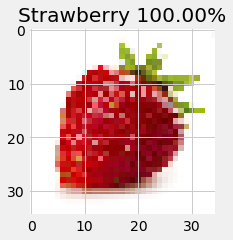

{'Apple Braeburn': '0.00%',
 'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '94.66%',
 'Clementine': '0.00%',
 'Cocos': '0.00%',
 'Lemon': '0.00%',
 'Limes': '0.00%',
 'Mandarin': '0.00%',
 'Orange': '0.00%',
 'Peach': '0.00%',
 'Pineapple': '0.00%',
 'Plum': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '5.34%',
 'Strawberry': '0.00%'}
Prediction: Banana (class 3) 94.66%


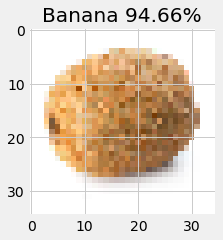

{'Apple Braeburn': '0.00%',
 'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '99.86%',
 'Clementine': '0.01%',
 'Cocos': '0.00%',
 'Lemon': '0.00%',
 'Limes': '0.00%',
 'Mandarin': '0.00%',
 'Orange': '0.00%',
 'Peach': '0.00%',
 'Pineapple': '0.00%',
 'Plum': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.04%',
 'Strawberry': '0.09%'}
Prediction: Banana (class 3) 99.86%


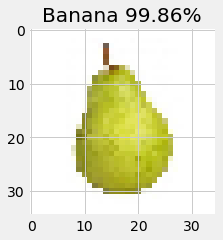

{'Apple Braeburn': '0.00%',
 'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Cocos': '0.00%',
 'Lemon': '0.00%',
 'Limes': '0.00%',
 'Mandarin': '0.00%',
 'Orange': '0.00%',
 'Peach': '0.00%',
 'Pineapple': '100.00%',
 'Plum': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '0.00%'}
Prediction: Pineapple (class 11) 100.00%


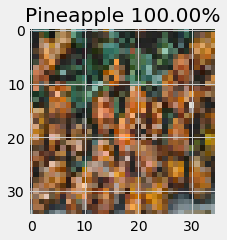

{'Apple Braeburn': '0.00%',
 'Apricot': '0.00%',
 'Avocado': '0.00%',
 'Banana': '0.00%',
 'Clementine': '0.00%',
 'Cocos': '0.00%',
 'Lemon': '0.00%',
 'Limes': '0.00%',
 'Mandarin': '0.00%',
 'Orange': '0.00%',
 'Peach': '0.00%',
 'Pineapple': '0.00%',
 'Plum': '0.00%',
 'Pomegranate': '0.00%',
 'Raspberry': '0.00%',
 'Strawberry': '100.00%'}
Prediction: Strawberry (class 15) 100.00%


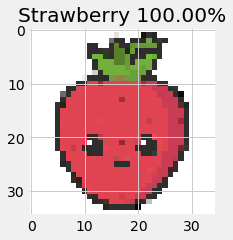

In [ ]:
images_for_prediction = [filename for filename in sorted(os.listdir(prediction_path)) if filename.endswith(".jpg")]

for filename in images_for_prediction:
  show_image = load_img(path=prediction_path+'/'+filename, target_size=(im_size,im_size,channels))
  loaded_image=load_img(path=prediction_path+'/'+filename, target_size=(im_size,im_size,channels), grayscale=True)
  """loaded_image = cv.imread(f"{prediction_path}/{filename}",0)
  loaded_image = cv.resize(loaded_image,(im_size,im_size))"""
  img_array= img_to_array(loaded_image)/255.

  img_np_array = np.expand_dims(img_array, axis=0)
  predictions = my_model.predict(img_np_array)
  classidx=np.argmax(predictions[0])
  label=trained_classes_labels[classidx]

  predictions_pct = ["{:.2f}%".format(prob * 100) for prob in predictions[0]]
  pprint(dict(zip(trained_classes_labels, predictions_pct)))
  print("Prediction: %s (class %s) %s" % (label, classidx, predictions_pct[classidx]))

  plt.figure(figsize=(3,4))
  plt.imshow(show_image)
  plt.title("%s %s" % (label, predictions_pct[classidx]))
  plt.show()

In [ ]:
batch_size = 
num_of_test_samples = 2434
Y_pred = my_model.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

NameError: ignored